In [87]:
!python -m pip install numpy pandas prophet matplotlib

In [88]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from prophet import Prophet
from datetime import timedelta
from datetime import timezone

mpl.style.use("seaborn")

In [89]:
dataframe = pd.read_csv(
    "data/germany_vaccinations_timeseries_v2.tsv",
    sep="\t",
    parse_dates=["date"]
)
dataframe.head()

,date,dosen_kumulativ,dosen_differenz_zum_vortag,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_biontech_kumulativ,dosen_moderna_kumulativ,dosen_astrazeneca_kumulativ,personen_erst_kumulativ,personen_voll_kumulativ,...,indikation_beruf_erst,indikation_medizinisch_erst,indikation_pflegeheim_erst,indikation_alter_voll,indikation_beruf_voll,indikation_medizinisch_voll,indikation_pflegeheim_voll,dosen_dim_kumulativ,dosen_kbv_kumulativ,dosen_johnson_kumulativ
0,2020-12-27,24503,24503,24492,11,24503,0,0,24492,11,...,8590,1305,12536,41,67,0,68,24503,0,0
1,2020-12-28,42885,18382,18382,0,42885,0,0,42874,11,...,15721,1991,21276,41,67,0,68,42885,0,0
2,2020-12-29,92346,49461,48872,589,92346,0,0,91746,600,...,40420,3107,40099,265,314,0,409,92346,0,0
3,2020-12-30,154819,62473,62469,4,154819,0,0,154215,604,...,73050,4901,62794,267,315,0,412,154819,0,0
4,2020-12-31,204883,50064,49924,140,204883,0,0,204139,744,...,96367,6752,83476,314,352,0,489,204883,0,0


In [90]:
df_german_holidays = pd.read_csv(
    "data/german_holidays.csv",
    parse_dates=["Tag"],
    sep=";"
    )["Tag"]

In [91]:
COLUMN="dosen_kumulativ"

df_kumulative = dataframe[["date",COLUMN]]

column_rename_schema = {
    'date':'ds',
    COLUMN:'y',
}

df_kumulative.rename(columns = column_rename_schema, inplace = True)

df_kumulative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      121 non-null    datetime64[ns]
 1   y       121 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.0 KB
/home/codedrift/.local/share/virtualenvs/jupyter-Vg80K4El/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


<AxesSubplot:xlabel='ds'>

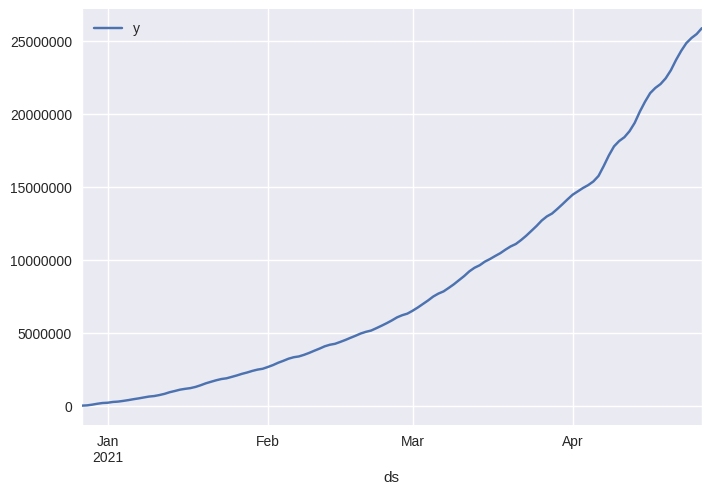

In [92]:

fig_forecast = plt.figure(dpi=100)

fig_forecast.set_facecolor("white")

ax= fig_forecast.gca()
# disable scientific numbers
ax.ticklabel_format(useOffset=False, style='plain')

df_kumulative.plot(kind="line", x="ds", y="y", ax=ax)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


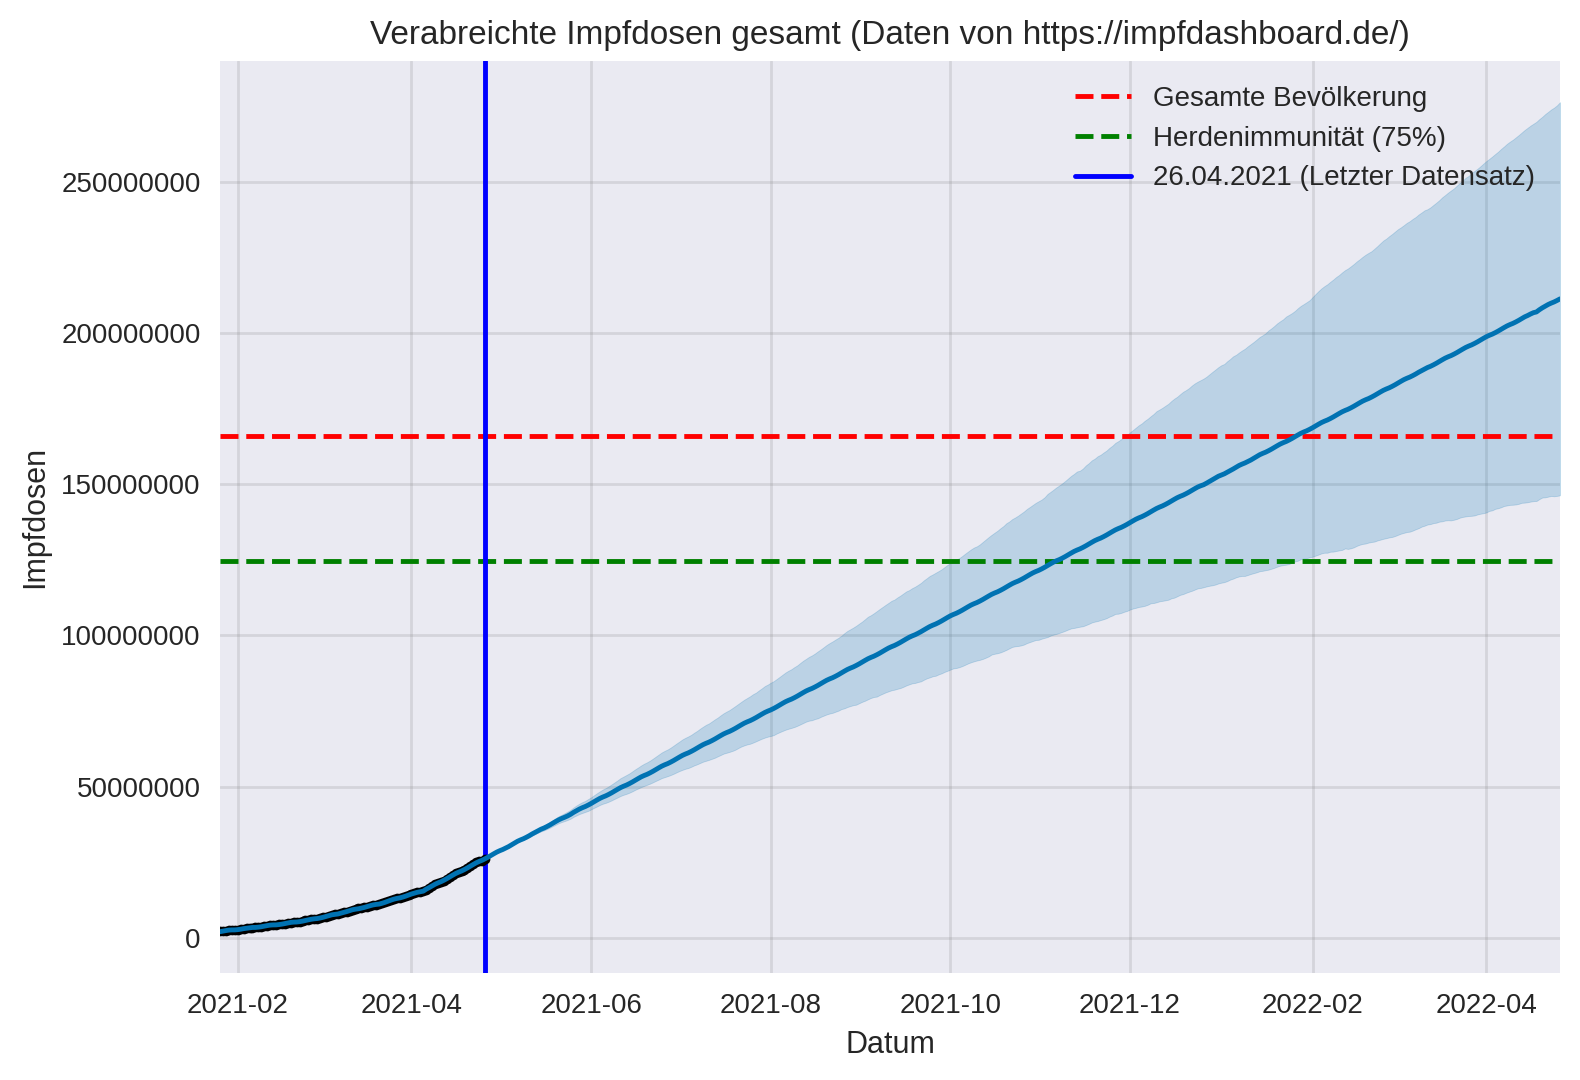

In [97]:
holidays = pd.DataFrame({
  'holiday': 'Deutscher Feiertag',
  'ds': df_german_holidays,
  'lower_window': 0,
  'upper_window': 1,
})

DAYS_FORECAST = 365

prophet = Prophet(weekly_seasonality=True, holidays=holidays)

prophet.add_country_holidays(country_name = 'DE')

prophet.fit(df_kumulative[30:])

future = prophet.make_future_dataframe(periods=DAYS_FORECAST)

forecast = prophet.predict(future)

fig_forecast = plt.figure(dpi=200)

fig_forecast.set_facecolor("white")

ax= fig_forecast.gca()
# disable scientific numbers
ax.ticklabel_format(useOffset=False, style='plain')

german_population = 83020000 * 2
german_population_herd = german_population * 0.75

first_date = df_kumulative["ds"].loc[0] + timedelta(days=30)
last_date = df_kumulative["ds"].loc[len(df_kumulative) - 1]

ax.axhline(y=german_population , label = "Gesamte Bevölkerung", color='r', ls='--')
ax.axhline(y=german_population_herd,label = "Herdenimmunität (75%)", color='g', ls='--')

ax.axvline(x=last_date,color='b', label = "26.04.2021 (Letzter Datensatz)")

plt.xlim([first_date, last_date + timedelta(days=DAYS_FORECAST)])

plt.legend()

ax.set_title('Verabreichte Impfdosen gesamt (Daten von https://impfdashboard.de/)')

# ax.plot(df_kumulative["ds"], german_population, '-g')
# ax.plot(first_date, german_population_herd, last_date, german_population_herd, marker = 'o')


prophet_plot_forecast_fig = prophet.plot(forecast, ax=ax, xlabel="Datum", ylabel="Impfdosen");

prophet_plot_forecast_fig.savefig('output/forecast.png')

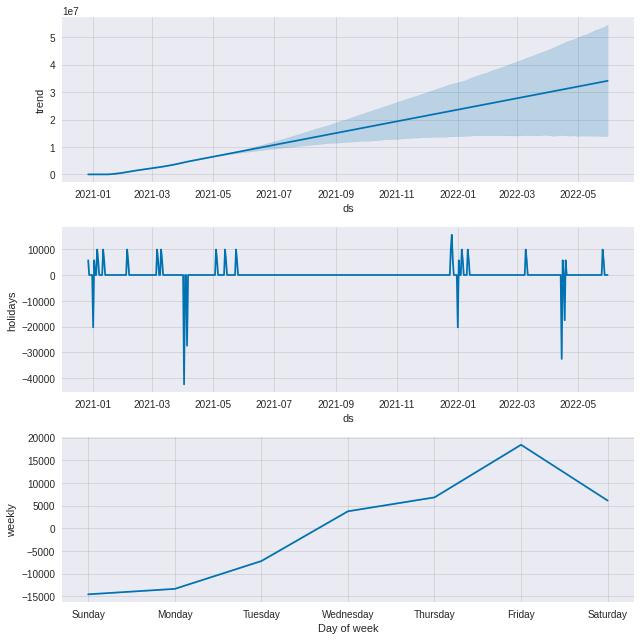

In [70]:
prophet.plot_components(forecast);